In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable 
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib as mpl
from matplotlib import pyplot as plt
from collections import namedtuple

from tqdm import tqdm
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
!pip install --editable .

Obtaining file:///home/jupyter/neuron-hidden-inference
  Preparing metadata (setup.py) ... done
  Attempting uninstall: helper-functions
    Found existing installation: helper-functions 0.1.2
    Uninstalling helper-functions-0.1.2:
      Successfully uninstalled helper-functions-0.1.2
  Running setup.py develop for helper-functions


In [3]:
from helper_functions import get_default_device, to_device
from helper_functions import evaluate_model, r2_loss

In [6]:
device = get_default_device()
print(f'device: {device} \ndevice name: {torch.cuda.get_device_name()}')

device: cuda 
device name: Tesla V100-SXM2-16GB


In [5]:
# Globals
VAL_RATIO = 0.2
BATCH_SIZE = 256
NUM_FEATURES = 10 
loss_fn = nn.MSELoss()

In [7]:
# Set random seeds for numpy and torch
np.random.seed(42)
random_seed = 42
torch.manual_seed(random_seed)

# Encoder 


In [8]:
class neuron_unit_encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(10,1).to(device)
    self.act1 = nn.Sigmoid()

  def forward(self,x):
    x = self.linear1(x)
    x = self.act1(x)
    return x

In [9]:
model_e = neuron_unit_encoder()

# Decoder 


In [10]:
class neuron_unit_decoder_w_hidden_init_fix(nn.Module): 
  '''
    - Has the same variance as the input features 
    - Has the weights forn the hidden acitvity as 1, to remove the
    redundancy 
  '''
  def __init__(self,train_size):
    super().__init__()
    self.linear1 = nn.Linear(10,1) 
    self.act1 = nn.Sigmoid()
    self.h_activity_vec = torch.nn.Parameter(torch.normal(0,1, size=(train_size,1))) 
    
    # Initialize the weights  of the hidden  vector by 1
    # Equal  to  make the weihgt of the the linear layer's last col to be 1 
   
    nn.init.constant_(self.linear1.weight[0,-1].data, 1)
    
  def forward(self,x):    
    # Truncate the last column of x, since that's the index
    # Note: only one example of the training data gets passed on during the forward pass
    #       so the number of rows here are 1, not 1000 

    input_wo_time = x[:,:-1].to(device) # Exclude the timepoint column [1,9]
    timepoint = x[:,-1].to(device) # [1]
    
    input_to_network = torch.cat((input_wo_time, self.h_activity_vec[timepoint.long()-1]), dim = 1).to(device) # [1,10]

    x = input_to_network
    x = self.linear1(x)
    x = self.act1(x)
    return x

# Training loop 

In [18]:
def train_decoder_w_hidden_w_var_penalty(model, datagen, loss_fn, var_coeff, n_epochs=50, learning_rate=1e-4):

  params = model.parameters()
  optimizer = torch.optim.Adam(params, lr=learning_rate)
  
  model_training_params = dict()
  model_training_params['loss_vals'] = []
  model_training_params['l2_loss_vals'] = []
  model_training_params['validation_loss'] = []
  model_training_params['n_epochs'] = n_epochs
  model_training_params['corr_vals'] = []
  gt_var = torch.var(datagen.original)

  for i in tqdm(range(n_epochs)):
    epoch_loss= []
    epoch_l2_loss = [] 
    epoch_val_loss = []
    
    for xb,yb in datagen.train_dl_hidden:
      out = model(xb).to(device)
      yb = yb.to(device)
      loss = loss_fn(out, yb)
            
      hidden_var = torch.var(model.h_activity_vec)
      var_diff  = (hidden_var-  gt_var)**2
      var_loss = torch.maximum(var_diff,torch.tensor(0))
      l2_loss = var_loss 
               
      loss = loss + var_loss*var_coeff # The coefficient is large, can go to inf
      
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
      epoch_loss.append(loss.item())
      epoch_l2_loss.append(l2_loss.item())
    
    
    with torch.no_grad():
        model.eval()
        for xb, yb in datagen.test_dl_hidden:
            pred = model(xb).to(device)
            yb = yb.to(device)
            val_loss = loss_fn(pred,yb)
            epoch_val_loss.append(val_loss.item())
            

    corr = r2_loss(model.h_activity_vec, datagen.original)
    model_training_params['corr_vals'].append(corr)
 
    model_training_params['loss_vals'].append(sum(epoch_loss)/len(epoch_loss))
    model_training_params['l2_loss_vals'].append(sum(epoch_l2_loss)/len(epoch_l2_loss))
    model_training_params['validation_loss'].append(sum(epoch_val_loss)/len(epoch_val_loss))
    
    
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | train loss: {loss.item():}')

  return model_training_params

# Poisson dataset generation

In [11]:
def generate_dataset_poisson(dataset_size, rate_type, rate = 1,val_ratio = VAL_RATIO, batch_size = BATCH_SIZE, num_features = NUM_FEATURES, add_GWN  = False ):
    '''
    Generate the dataset containing dataset_size number of samples with num_features features.
    The samples have a mean of 0 and a std of 1
    
    Args:
        dataset_size: Size of the dataset (split into 80% training, 20% validation)
        num_features: number of synapeses for the model neuron
        add_GWN: Flag to add Gaussian white noise to the data
    
    Returns: 
    PyTorch dataloaders train_dataloader and test_dataloader 
    '''
    # Example: 
    # Total datset size = 1250 samples
    # Training set of 1000 samples, test set of 250 samples
    
    if rate_type == 'variable':
        rates = torch.rand(dataset_size, num_features)* rate # Rates between [0,1) 
    elif rate_type == 'constant':
        rates = torch.ones(dataset_size, num_features)* rate
    x = torch.poisson(rates).to(device)
    
    if add_GWN:
        noise = gen_GWN(dataset_size, num_features).to(device)
        x = x + noise
    
    train_size = int((1-val_ratio)*dataset_size)
    val_size = int(val_ratio*dataset_size)

    inputs = x[:train_size]
    inputs_val = x[train_size:]
    
    original =  inputs[:,-1].reshape(train_size,1)

    # print(f'Train input with shape {inputs.shape} = \n{inputs} \n\nTest input with shape {inputs_val.shape} = \n{inputs_val}')
    
    # Generate outputs using the encoder model
    with torch.no_grad():
      output = model_e(inputs)
      output_val = model_e(inputs_val)
    
    # print(f'Output shape: {output.shape}\nOutput val shape: {output_val.shape}')
    
    timepoints = torch.arange(start = 1, end = inputs.shape[0]+1).to(device) 
    timepoints = torch.reshape(timepoints,(inputs.shape[0],1))
    # print(f'timepoints shape: {timepoints.shape}')

    # Do the same operations for the validation set
    timepoints_val = torch.arange(start = 1, end = inputs_val.shape[0]+1).to(device) 
    timepoints_val = torch.reshape(timepoints_val, (inputs_val.shape[0],1))
    # print(f'timepoints_val shape: {timepoints_val.shape}')

    input_w_time = torch.cat((inputs, timepoints), dim = 1)
    # print(input_w_time[0]) 

    input_w_time_val = torch.cat((inputs_val, timepoints_val), dim = 1)
    # print(input_w_time_val[0])

    # Create the input with missing 10th neuron values
    inputs = inputs.to(device)
    inputs_val = inputs_val.to(device)

    input_w_hidden = inputs[:,:9].clone() # [1000,9]   # Change '9' for future features (not 10)
    input_w_hidden_val = inputs_val[:,:9].clone()

    # print(input_w_hidden)
    input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim = 1).to(device) # [1000,10]
    # print(input_w_time_hidden)
    input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim = 1).to(device)
    
    # This gets passed on to the decoder network as the input (x)

    # Creating the dataloader
    # train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    test_ds_hidden_params = TensorDataset(input_w_time_hidden_val, output_val)


    # batch_size = 256
    train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle = True)
    train_dl_hidden.device = device

    test_dl_hidden = DataLoader(test_ds_hidden_params, batch_size , shuffle = True)
    test_dl_hidden.device = device 


    next(iter(train_dl_hidden))
    next(iter(test_dl_hidden))
    
    return inputs, output, original, input_w_time_hidden, train_dl_hidden, test_dl_hidden

In [12]:
def init_datagen_poisson(dataset_size, rate_type, rate, val_ratio = VAL_RATIO):
    
    datagen = namedtuple('datagen',["inputs","output", "original","input_w_time_hidden", "train_dl_hidden", "test_dl_hidden", "train_size", "val_size"])
    datagen.train_size = int((1-val_ratio)*dataset_size)
    datagen.val_size = int(val_ratio*dataset_size)
    datagen.inputs, datagen.output, datagen.original, datagen.input_w_time_hidden, datagen.train_dl_hidden, datagen.test_dl_hidden= generate_dataset_poisson(dataset_size, rate_type, rate)
    return datagen

In [13]:
def run_dataset_sweep_poisson(dataset_size_list, rate_type, rate = 1, n_epochs = 20000, var = 1):
    for dataset_size in dataset_size_list:
        
        print(f'Training on {dataset_size} samples... \n\n')
        datagen = init_datagen_poisson(dataset_size, rate_type, rate)
        model_iter = neuron_unit_decoder_w_hidden_val_fixed(datagen.train_size, var).to(device)
        model_training_params = train_decoder_var_penalty_val_fix(model_iter, datagen, loss_fn, var_coeff = 1, n_epochs = n_epochs)
        
        evaluate_model(model = model_iter,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )
    return

In [14]:
# DELETE BELOW TESTING 

In [16]:
dataset_size = 125
datagen = init_datagen_poisson(dataset_size, 'variable' , 1)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

Dataset size: 125

Training size: 100
Validation size: 25


In [19]:
model_decoder_var_100samples =  neuron_unit_decoder_w_hidden_init_fix(datagen.train_size).to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(model_decoder_var_100samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4060/20000 [00:11<00:45, 346.97it/s]

iteration 4000/20000 | train loss: 0.03734685480594635


 40%|████      | 8055/20000 [00:23<00:34, 346.07it/s]

iteration 8000/20000 | train loss: 0.0043836249969899654


 60%|██████    | 12063/20000 [00:34<00:22, 345.82it/s]

iteration 12000/20000 | train loss: 0.0016591756138950586


 80%|████████  | 16062/20000 [00:46<00:11, 354.47it/s]

iteration 16000/20000 | train loss: 0.0015375151997432113


100%|██████████| 20000/20000 [00:57<00:00, 348.58it/s]

iteration 20000/20000 | train loss: 0.0011497966479510069


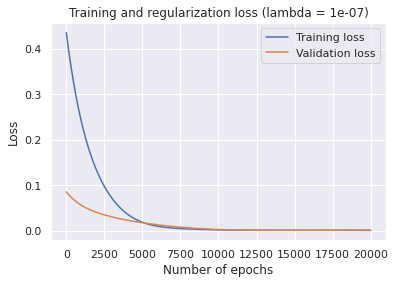

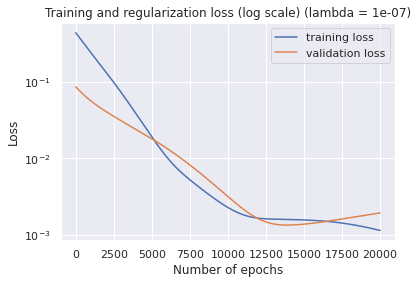

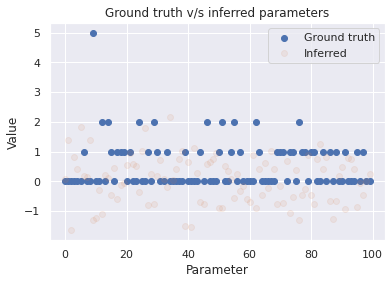

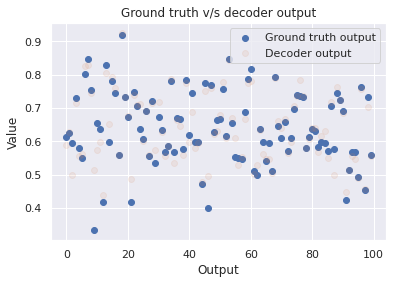

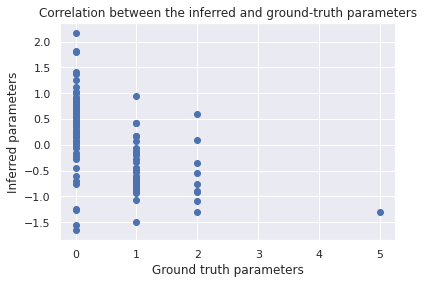

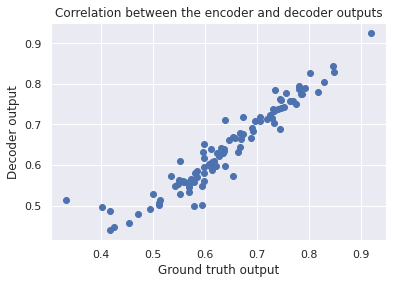

In [20]:
evaluate_model(model = model_decoder_var_100samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

# Standardizing the inputs

In [125]:
from torchvision import transforms

In [126]:
def generate_dataset_poisson_normalized(dataset_size, rate_type, rate = 1,val_ratio = VAL_RATIO, batch_size = BATCH_SIZE, num_features = NUM_FEATURES, add_GWN  = False ):
    '''
    Generate the dataset containing dataset_size number of samples with num_features features.
    The samples have a mean of 0 and a std of 1
    
    Args:
        dataset_size: Size of the dataset (split into 80% training, 20% validation)
        num_features: number of synapeses for the model neuron
        add_GWN: Flag to add Gaussian white noise to the data
    
    Returns: 
    PyTorch dataloaders train_dataloader and test_dataloader 
    '''
    # Example: 
    # Total datset size = 1250 samples
    # Training set of 1000 samples, test set of 250 samples
    
    # x = torch.normal(0, 1, size=(dataset_size,num_features)).to(device) # Mean = 0, std = 1
    if rate_type == 'variable':
        rates = torch.rand(dataset_size, num_features)* rate # Rates between [0,1) 
    elif rate_type == 'constant':
        rates = torch.ones(dataset_size, num_features)* rate
    x = torch.poisson(rates).to(device)
    
    if add_GWN:
        noise = gen_GWN(dataset_size, num_features).to(device)
        x = x + noise
    
    train_size = int((1-val_ratio)*dataset_size)
    val_size = int(val_ratio*dataset_size)
    
    # Normalize the input vector
    mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
    
    print("Mean, std and Var before normalization: ", mean, std, var)
    
    x = (x-mean)/std
    mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
    print("Mean, std and Var after normalization: ", mean, std, var)
    
    inputs = x[:train_size]
    inputs_val = x[train_size:]
    
    original =  inputs[:,-1].reshape(train_size,1)

    # print(f'Train input with shape {inputs.shape} = \n{inputs} \n\nTest input with shape {inputs_val.shape} = \n{inputs_val}')
    
    # Generate outputs using the encoder model
    with torch.no_grad():
      output = model_e(inputs)
      output_val = model_e(inputs_val)
    
    # print(f'Output shape: {output.shape}\nOutput val shape: {output_val.shape}')
    
    timepoints = torch.arange(start = 1, end = inputs.shape[0]+1).to(device) 
    timepoints = torch.reshape(timepoints,(inputs.shape[0],1))
    # print(f'timepoints shape: {timepoints.shape}')

    # Do the same operations for the validation set
    timepoints_val = torch.arange(start = 1, end = inputs_val.shape[0]+1).to(device) 
    timepoints_val = torch.reshape(timepoints_val, (inputs_val.shape[0],1))
    # print(f'timepoints_val shape: {timepoints_val.shape}')

    input_w_time = torch.cat((inputs, timepoints), dim = 1)
    # print(input_w_time[0]) 

    input_w_time_val = torch.cat((inputs_val, timepoints_val), dim = 1)
    # print(input_w_time_val[0])

    # Create the input with missing 10th neuron values
    inputs = inputs.to(device)
    inputs_val = inputs_val.to(device)

    input_w_hidden = inputs[:,:9].clone() # [1000,9]   # Change '9' for future features (not 10)
    input_w_hidden_val = inputs_val[:,:9].clone()

    # print(input_w_hidden)
    input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim = 1).to(device) # [1000,10]
    # print(input_w_time_hidden)
    input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim = 1).to(device)
    
    # This gets passed on to the decoder network as the input (x)

    # Creating the dataloader
    # train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    test_ds_hidden_params = TensorDataset(input_w_time_hidden_val, output_val)


    # batch_size = 256
    train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle = True)
    train_dl_hidden.device = device

    test_dl_hidden = DataLoader(test_ds_hidden_params, batch_size , shuffle = True)
    test_dl_hidden.device = device 


    next(iter(train_dl_hidden))
    next(iter(test_dl_hidden))
    
    return inputs, output, original, input_w_time_hidden, train_dl_hidden, test_dl_hidden

In [127]:
def init_datagen_poisson_norm(dataset_size, rate_type, rate, val_ratio = VAL_RATIO):
    
    datagen = namedtuple('datagen',["inputs","output", "original","input_w_time_hidden", "train_dl_hidden", "test_dl_hidden", "train_size", "val_size"])
    datagen.train_size = int((1-val_ratio)*dataset_size)
    datagen.val_size = int(val_ratio*dataset_size)
    datagen.inputs, datagen.output, datagen.original, datagen.input_w_time_hidden, datagen.train_dl_hidden, datagen.test_dl_hidden= generate_dataset_poisson_normalized(dataset_size, rate_type, rate)
    return datagen

# Visualize the activity before the activation function is applied 

## Decoder with hooks 

In [23]:
class neuron_unit_decoder_w_hook(nn.Module): 
  def __init__(self,train_size, var = 1 ):
    super().__init__()
    self.linear1 = nn.Linear(10,1) 
    self.act1 = nn.Sigmoid()
    self.h_activity_vec = torch.nn.Parameter(torch.normal(0,var, size=(train_size,1)))     
    nn.init.constant_(self.linear1.weight[0,-1].data, 1)
    
  def forward(self, x, isVal = False):    
    if isVal == False:
        input_wo_time = x[:,:-1].to(device) # Exclude the timepoint column [1,9]
        timepoint = x[:,-1].to(device) # [1]
        input_to_network = torch.cat((input_wo_time, self.h_activity_vec[timepoint.long()-1]), dim = 1).to(device) # [1,10]
        
    if isVal == True:
        input_to_network = x
        assert input_to_network.shape[1] == self.linear1.in_features, "The validation dataset must have the same number of features as the model's input synapses"

    x = input_to_network
    x = self.linear1(x)
    x = self.act1(x)
    return x

## Training loop

In [24]:
def train_decoder_w_hooks(model, datagen, loss_fn, var_coeff, n_epochs=50, learning_rate=1e-4):

  params = model.parameters()
  optimizer = torch.optim.Adam(params, lr=learning_rate)
  
  model_training_params = dict()
  model_training_params['loss_vals'] = []
  model_training_params['l2_loss_vals'] = []
  model_training_params['validation_loss'] = []
  model_training_params['n_epochs'] = n_epochs
  model_training_params['corr_vals'] = []
  gt_var = torch.var(datagen.original)
  linear_act, act1_act = [],[]

  for i in tqdm(range(n_epochs)):
    epoch_loss= []
    epoch_l2_loss = [] 
    epoch_val_loss = []
    
    for xb,yb in datagen.train_dl_hidden:
      out = model(xb).to(device)
      linear_act.append(activation['linear1'])
      act1_act.append(activation['act1'])
        
      yb = yb.to(device)
      loss = loss_fn(out, yb)
    
      # norm = torch.linalg.vector_norm(model.h_activity_vec,ord = l_norm)
        
      hidden_var = torch.var(model.h_activity_vec)
      var_diff  = (hidden_var-  gt_var)**2
      var_loss = torch.maximum(var_diff,torch.tensor(0))
      l2_loss = var_loss 
               
      loss = loss + var_loss*var_coeff # The coefficient is large, can go to inf
      
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
      epoch_loss.append(loss.item())
      epoch_l2_loss.append(l2_loss.item())
    
    h_linear.remove()
    h_sig.remove()
    
    with torch.no_grad():
        model.eval()
        for xb, yb in datagen.test_dl_hidden:
            pred = model(xb).to(device)
            yb = yb.to(device)
            val_loss = loss_fn(pred,yb)
            epoch_val_loss.append(val_loss.item())
            

    corr = r2_loss(model.h_activity_vec, datagen.original)
    model_training_params['corr_vals'].append(corr)
 
    model_training_params['loss_vals'].append(sum(epoch_loss)/len(epoch_loss))
    model_training_params['l2_loss_vals'].append(sum(epoch_l2_loss)/len(epoch_l2_loss))
    model_training_params['validation_loss'].append(sum(epoch_val_loss)/len(epoch_val_loss))
    
    
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | train loss: {loss.item():}')

  return model_training_params

In [25]:
def getActivation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [21]:
def plot_sigmoid(range = 10, num_points = 100):
    x = np.linspace(-range, range, num_points)
    z = 1/(1 + np.exp(-x))
    sns.lineplot(x, z)
    plt.xlabel("x")
    plt.ylabel("Sigmoid(x)")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


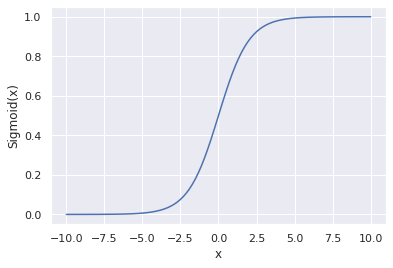

In [22]:
plot_sigmoid()


In [41]:
def plot_act_over_activation_fn(activation):
    # ip = datagen.input_w_time_hidden #[datset_size x features]
    plot_sigmoid()
    
    size = activation['linear1'].shape[0] # [num_samples x features]
    # size = datagen.inputs.cpu().shape[0]
    
    y = np.zeros((size,1))
    print(f'Shape of y: {y.shape}')
    # x = torch.reshape(activation['linear1'],(100,))
    print(f'Linear activation shape: {activation["linear1"].shape}')
    # plt.scatter(datagen.inputs.cpu(),y,alpha = 0.05)
    plt.scatter(activation['linear1'].cpu(),y,alpha = 0.1)
    plt.plot()
    
    return

In [37]:
activation['linear1'].shape

torch.Size([100, 1])

In [47]:
def plot_act_violinplot(activation, range = 10, datapoints = 100):
    ax1 = sns.set_style(style= None, rc= None)
    fig, ax1 = plt.subplots()
    
    x = np.linspace(-range, range, datapoints)
    z = 1/(1 + np.exp(-x)) # Sigmoid
    sns.lineplot(x, z) # Plot sigmoid 
    
    ax2 = ax1.twinx()
    # sns.violinplot(x= datagen.inputs.cpu().detach().numpy())
    sns.violinplot(x= activation['linear1'].cpu().detach().numpy())
    
    return

## 100 Samples

In [32]:
dataset_size = 125
datagen = init_datagen_poisson(dataset_size, 'constant', 1)
model_decoder_100samples =  neuron_unit_decoder_w_hook(datagen.train_size).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_100samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_100samples.act1.register_forward_hook(getActivation('act1'))

Dataset size: 125

Training size: 100
Validation size: 25


In [33]:
model_training_params = train_decoder_w_hooks(model_decoder_100samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4056/20000 [00:11<00:43, 366.32it/s]

iteration 4000/20000 | train loss: 0.01655244082212448


 40%|████      | 8068/20000 [00:22<00:33, 359.89it/s]

iteration 8000/20000 | train loss: 0.0036907268222421408


 60%|██████    | 12051/20000 [00:33<00:22, 360.45it/s]

iteration 12000/20000 | train loss: 0.0013349740765988827


 80%|████████  | 16039/20000 [00:44<00:11, 358.15it/s]

iteration 16000/20000 | train loss: 0.0009638877818360925


100%|██████████| 20000/20000 [00:55<00:00, 359.58it/s]

iteration 20000/20000 | train loss: 0.0005440218956209719


Shape of y: (100, 1)
Linear activation shape: torch.Size([100, 1])


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


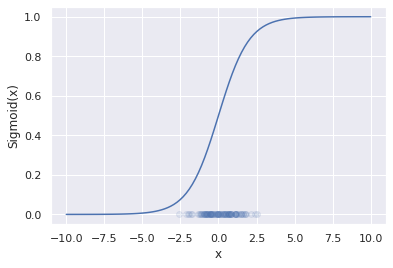

In [42]:
plot_act_over_activation_fn(activation)

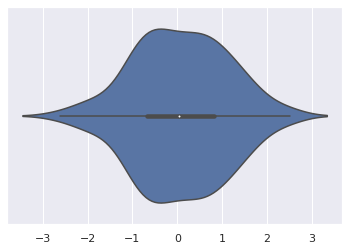

In [46]:
plot_act_violinplot(activation)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


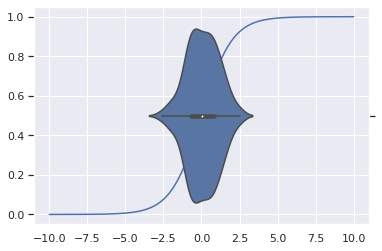

In [48]:
plot_act_violinplot(activation)

## 1000 Samples 

In [50]:
dataset_size = 1250
datagen = init_datagen_poisson(dataset_size, 'constant', 1)
model_decoder_1000samples =  neuron_unit_decoder_w_hook(datagen.train_size).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_1000samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_1000samples.act1.register_forward_hook(getActivation('act1'))

Dataset size: 1250

Training size: 1000
Validation size: 250


In [52]:
model_training_params = train_decoder_w_hooks(model_decoder_1000samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4002/20000 [00:53<03:27, 77.05it/s]

iteration 4000/20000 | train loss: 0.0017492762999609113


 40%|████      | 8015/20000 [01:48<02:36, 76.40it/s]

iteration 8000/20000 | train loss: 0.0008657619473524392


 60%|██████    | 12013/20000 [02:42<01:43, 77.14it/s]

iteration 12000/20000 | train loss: 0.0002391548769082874


 80%|████████  | 16006/20000 [03:36<01:01, 64.50it/s]

iteration 16000/20000 | train loss: 2.2212869225768372e-05


100%|██████████| 20000/20000 [04:30<00:00, 73.94it/s]

iteration 20000/20000 | train loss: 1.4416857538890326e-06


Shape of y: (232, 1)
Linear activation shape: torch.Size([232, 1])


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


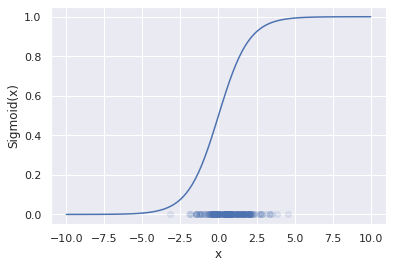

In [53]:
plot_act_over_activation_fn(activation)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


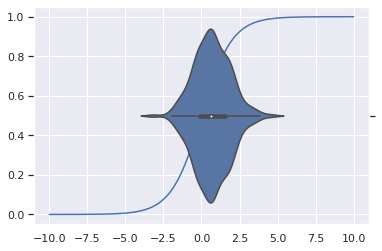

In [54]:
plot_act_violinplot(activation)

In [102]:
# Standardizing the inputs

# Increasing variance for the hidden activity vector (Poisson input) 


## 3x variance

### Non-standardized

#### 100 samples

In [103]:
dataset_size = 125
datagen = init_datagen_poisson(dataset_size, 'constant', 1)
model_decoder_100samples =  neuron_unit_decoder_w_hook(datagen.train_size, var = 3).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_100samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_100samples.act1.register_forward_hook(getActivation('act1'))

Dataset size: 125

Training size: 100
Validation size: 25


In [104]:
model_training_params = train_decoder_w_hooks(model_decoder_100samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4039/20000 [00:11<00:42, 373.95it/s]

iteration 4000/20000 | train loss: 75.23516082763672


 40%|████      | 8043/20000 [00:22<00:32, 364.00it/s]

iteration 8000/20000 | train loss: 50.40792465209961


 60%|██████    | 12053/20000 [00:33<00:21, 365.31it/s]

iteration 12000/20000 | train loss: 32.988346099853516


 80%|████████  | 16060/20000 [00:44<00:10, 364.70it/s]

iteration 16000/20000 | train loss: 20.945587158203125


100%|██████████| 20000/20000 [00:55<00:00, 362.86it/s]

iteration 20000/20000 | train loss: 12.797491073608398


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Shape of y: (100, 1)
Linear activation shape: torch.Size([100, 1])


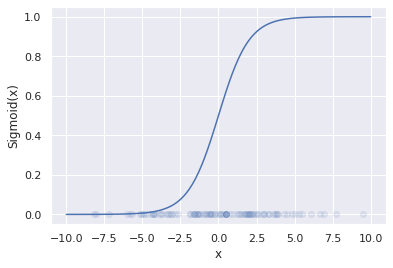

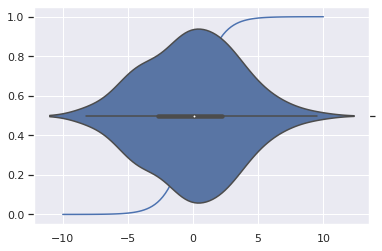

In [105]:
plot_act_over_activation_fn(activation)
plot_act_violinplot(activation)

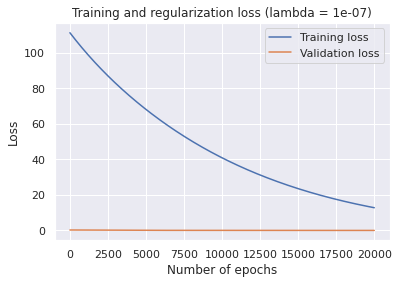

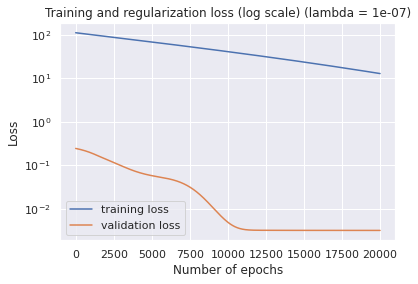

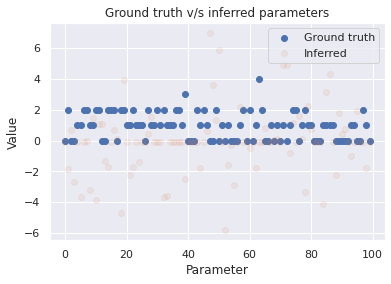

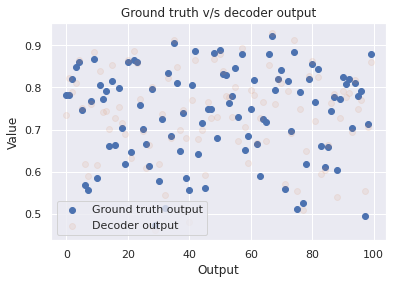

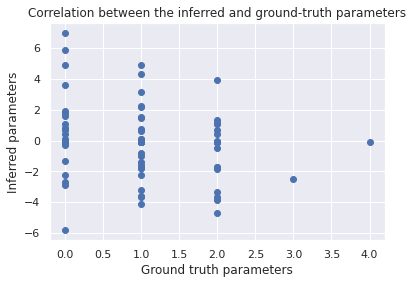

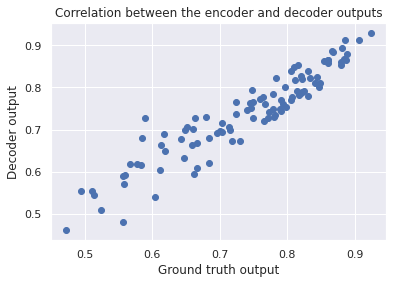

In [106]:
evaluate_model(model = model_decoder_100samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

#### 1000 Samples

In [107]:
dataset_size = 1250
datagen = init_datagen_poisson(dataset_size, 'constant', 1)
model_decoder_1000samples =  neuron_unit_decoder_w_hook(datagen.train_size, var = 3).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_1000samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_1000samples.act1.register_forward_hook(getActivation('act1'))

Dataset size: 1250

Training size: 1000
Validation size: 250


In [108]:
model_training_params = train_decoder_w_hooks(model_decoder_1000samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4015/20000 [00:53<03:29, 76.41it/s]

iteration 4000/20000 | train loss: 6.041158199310303


 40%|████      | 8013/20000 [01:47<02:53, 69.14it/s]

iteration 8000/20000 | train loss: 0.11084124445915222


 60%|██████    | 12015/20000 [02:41<01:43, 77.32it/s]

iteration 12000/20000 | train loss: 0.0017584164161235094


 80%|████████  | 16008/20000 [03:34<00:51, 78.17it/s]

iteration 16000/20000 | train loss: 0.0007186767761595547


100%|██████████| 20000/20000 [04:27<00:00, 74.81it/s]


iteration 20000/20000 | train loss: 0.0002317915641469881


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Shape of y: (232, 1)
Linear activation shape: torch.Size([232, 1])


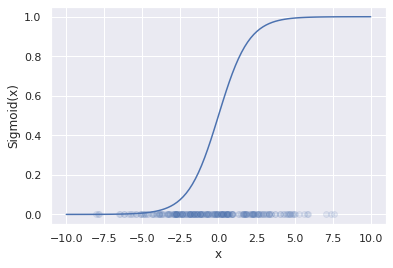

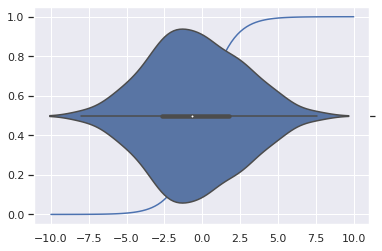

In [109]:
plot_act_over_activation_fn(activation)
plot_act_violinplot(activation)

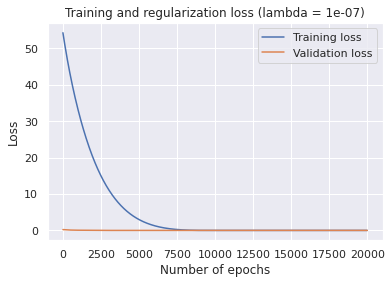

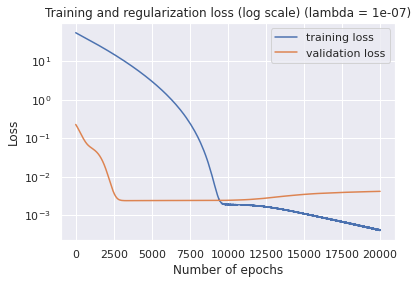

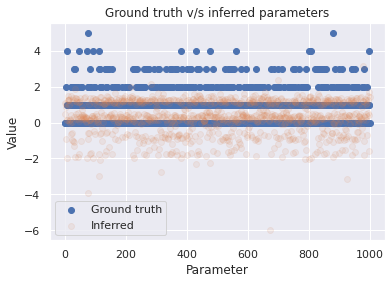

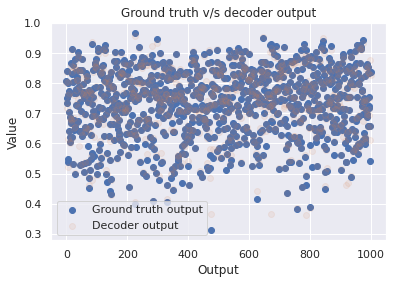

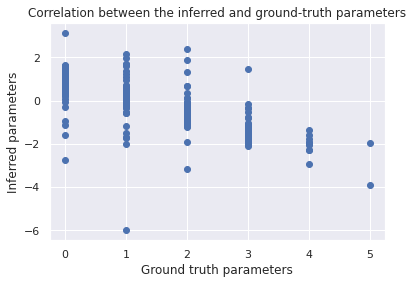

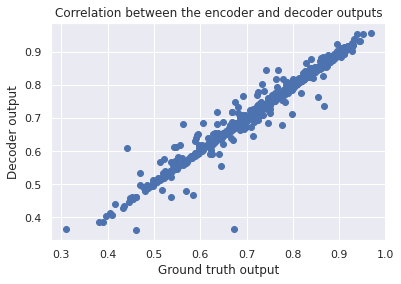

In [110]:
evaluate_model(model = model_decoder_1000samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

### Standardized

#### 100 samples

In [128]:
dataset_size = 125
datagen = init_datagen_poisson_norm(dataset_size, 'constant', 1)
model_decoder_100samples =  neuron_unit_decoder_w_hook(datagen.train_size, var = 3).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_100samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_100samples.act1.register_forward_hook(getActivation('act1'))

Mean, std and Var before normalization:  tensor(1.0456, device='cuda:0') tensor(1.0274, device='cuda:0') tensor(1.0556, device='cuda:0')
Mean, std and Var after normalization:  tensor(5.6458e-08, device='cuda:0') tensor(1., device='cuda:0') tensor(1.0000, device='cuda:0')
Dataset size: 125

Training size: 100
Validation size: 25


In [129]:
model_training_params = train_decoder_w_hooks(model_decoder_100samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4055/20000 [00:11<00:44, 361.77it/s]

iteration 4000/20000 | train loss: 27.3758602142334


 40%|████      | 8062/20000 [00:22<00:34, 341.59it/s]

iteration 8000/20000 | train loss: 15.339969635009766


 60%|██████    | 12041/20000 [00:33<00:22, 360.74it/s]

iteration 12000/20000 | train loss: 7.989186763763428


 80%|████████  | 16052/20000 [00:45<00:11, 357.06it/s]

iteration 16000/20000 | train loss: 3.743283271789551


100%|██████████| 20000/20000 [00:56<00:00, 355.75it/s]

iteration 20000/20000 | train loss: 1.4878129959106445


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Shape of y: (100, 1)
Linear activation shape: torch.Size([100, 1])


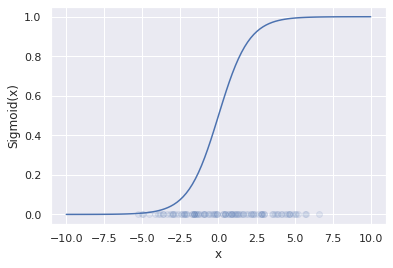

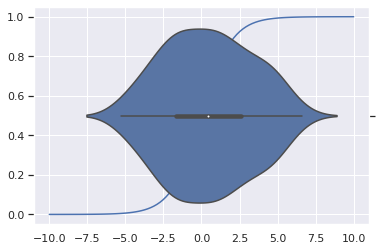

In [130]:
plot_act_over_activation_fn(activation)
plot_act_violinplot(activation)

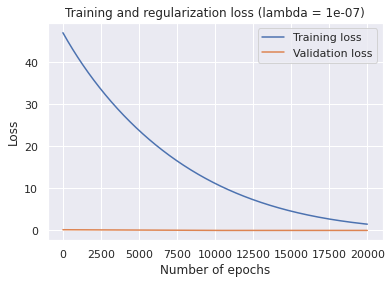

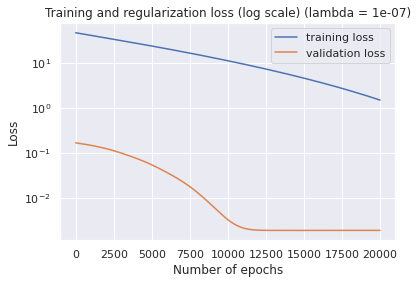

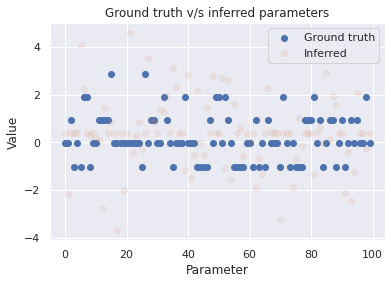

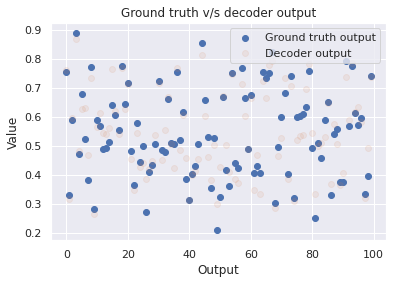

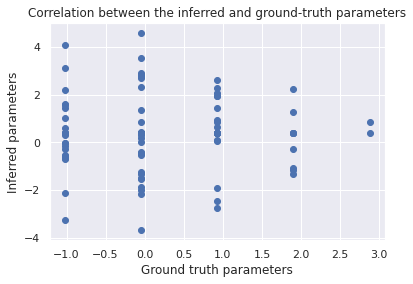

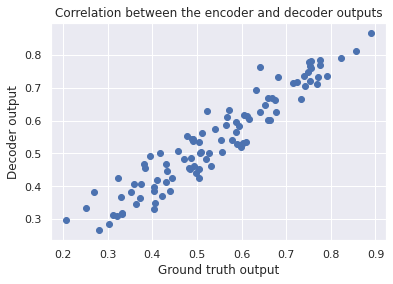

In [131]:
evaluate_model(model = model_decoder_100samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

#### 1000 Samples

In [134]:
dataset_size = 1250
datagen = init_datagen_poisson_norm(dataset_size, 'constant', 1)
model_decoder_1000samples =  neuron_unit_decoder_w_hook(datagen.train_size, var = 5).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_1000samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_1000samples.act1.register_forward_hook(getActivation('act1'))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [133]:
model_training_params = train_decoder_w_hooks(model_decoder_100samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

  0%|          | 0/20000 [00:00<?, ?it/s]
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [0,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [2,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [3,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [4,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/

KeyError: 'linear1'

/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [11,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [13,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [14,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], thread: [15,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [0,0,0], t

In [ ]:
plot_act_over_activation_fn(activation)
plot_act_violinplot(activation)

In [ ]:
evaluate_model(model = model_decoder_1000samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

## 5x variance 

### 100 samples

In [111]:
dataset_size = 125
datagen = init_datagen_poisson(dataset_size, 'constant', 1)
model_decoder_100samples =  neuron_unit_decoder_w_hook(datagen.train_size, var = 5).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_100samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_100samples.act1.register_forward_hook(getActivation('act1'))

Dataset size: 125

Training size: 100
Validation size: 25


In [112]:
model_training_params = train_decoder_w_hooks(model_decoder_100samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4064/20000 [00:11<00:44, 358.71it/s]

iteration 4000/20000 | train loss: 346.232177734375


 40%|████      | 8064/20000 [00:22<00:33, 356.27it/s]

iteration 8000/20000 | train loss: 261.0126037597656


 60%|██████    | 12049/20000 [00:33<00:22, 361.08it/s]

iteration 12000/20000 | train loss: 194.7827911376953


 80%|████████  | 16050/20000 [00:44<00:10, 360.63it/s]

iteration 16000/20000 | train loss: 143.6548614501953


100%|██████████| 20000/20000 [00:55<00:00, 361.36it/s]

iteration 20000/20000 | train loss: 104.50406646728516


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Shape of y: (100, 1)
Linear activation shape: torch.Size([100, 1])


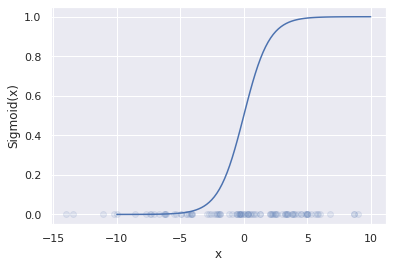

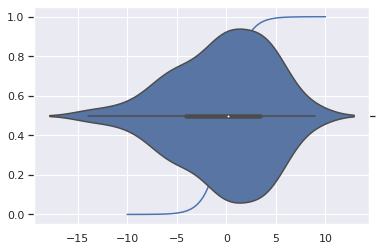

In [113]:
plot_act_over_activation_fn(activation)
plot_act_violinplot(activation)

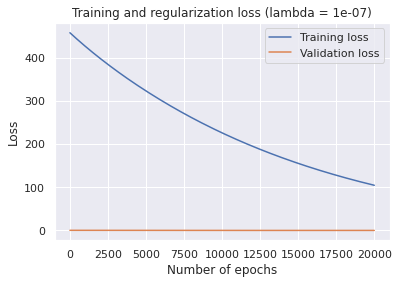

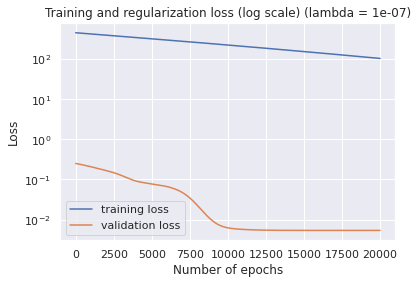

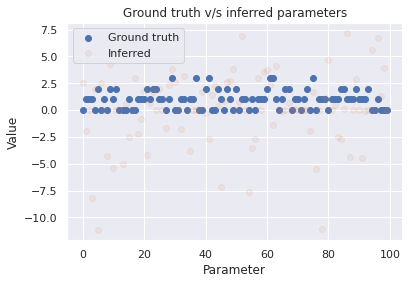

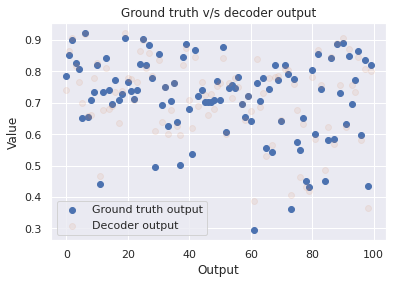

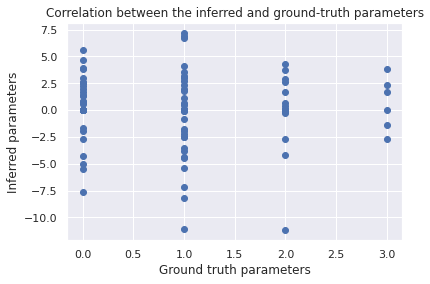

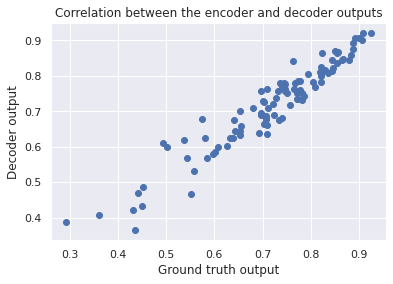

In [114]:
evaluate_model(model = model_decoder_100samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

### 1000 samples

In [120]:
dataset_size = 1250
datagen = init_datagen_poisson(dataset_size, 'constant', 1)
model_decoder_1000samples =  neuron_unit_decoder_w_hook(datagen.train_size, var = 5).to(device)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

activation = {}

h_linear = model_decoder_1000samples.linear1.register_forward_hook(getActivation('linear1'))
h_sig =model_decoder_1000samples.act1.register_forward_hook(getActivation('act1'))

Dataset size: 1250

Training size: 1000
Validation size: 250


In [121]:
model_training_params = train_decoder_w_hooks(model_decoder_1000samples, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4011/20000 [00:53<03:25, 77.66it/s]

iteration 4000/20000 | train loss: 224.22274780273438


 40%|████      | 8010/20000 [01:46<02:32, 78.48it/s]

iteration 8000/20000 | train loss: 67.36055755615234


 60%|██████    | 12015/20000 [02:39<01:41, 78.99it/s]

iteration 12000/20000 | train loss: 16.249422073364258


 80%|████████  | 16009/20000 [03:33<00:50, 78.63it/s]

iteration 16000/20000 | train loss: 2.538713216781616


100%|██████████| 20000/20000 [04:26<00:00, 75.02it/s]


iteration 20000/20000 | train loss: 0.09462966024875641


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Shape of y: (232, 1)
Linear activation shape: torch.Size([232, 1])


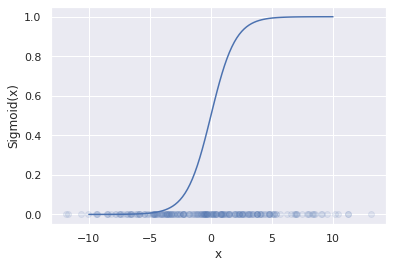

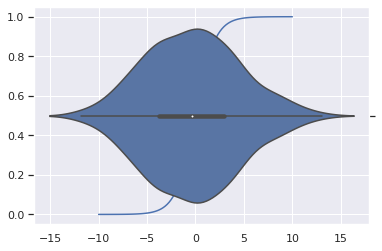

In [122]:
plot_act_over_activation_fn(activation)
plot_act_violinplot(activation)

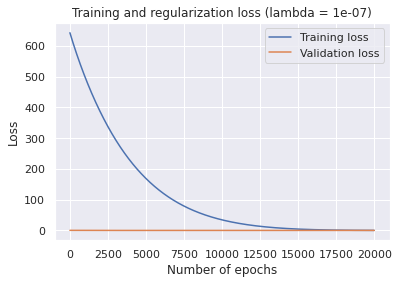

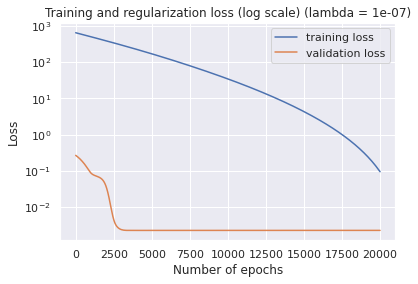

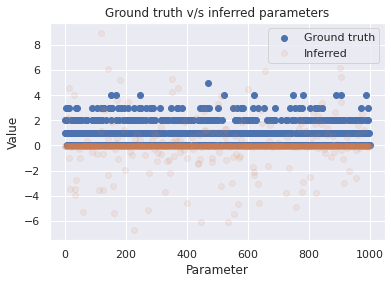

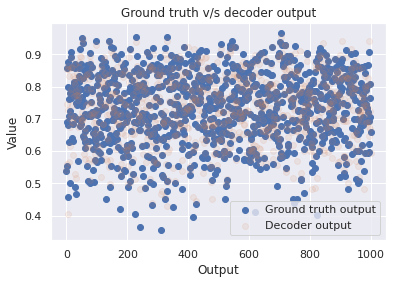

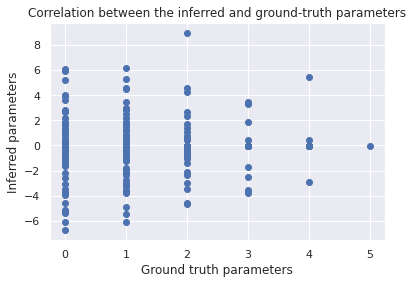

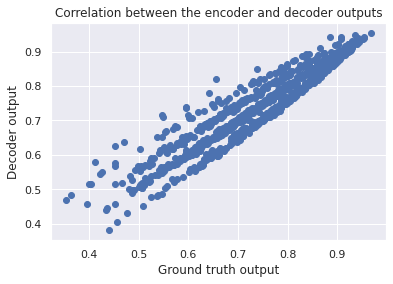

In [124]:
evaluate_model(model = model_decoder_1000samples,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

# Positive control test


## Gaussian input

In [90]:
def generate_dataset_gauss_fully_obs(dataset_size, val_ratio = VAL_RATIO, batch_size = BATCH_SIZE, num_features = NUM_FEATURES, add_GWN  = False ):
    '''
    Generate the dataset containing dataset_size number of samples with num_features features.
    The samples have a mean of 0 and a std of 1
    
    Args:
        dataset_size: Size of the dataset (split into 80% training, 20% validation)
        num_features: number of synapeses for the model neuron
        add_GWN: Flag to add Gaussian white noise to the data
    
    Returns: 
    PyTorch dataloaders train_dataloader and test_dataloader 
    '''
    # Example: 
    # Total datset size = 1250 samples
    # Training set of 1000 samples, test set of 250 samples

    x = torch.normal(0, 1, size=(dataset_size,num_features)).to(device) # Mean = 0, std = 1
    
    if add_GWN:
        noise = gen_GWN(dataset_size, num_features).to(device)
        x = x + noise
    
    train_size = int((1-val_ratio)*dataset_size)
    val_size = int(val_ratio*dataset_size)

    inputs = x[:train_size]
    inputs_val = x[train_size:]
    
    original =  inputs[:,-1].reshape(train_size,1)

    # print(f'Train input with shape {inputs.shape} = \n{inputs} \n\nTest input with shape {inputs_val.shape} = \n{inputs_val}')
    
    # Generate outputs using the encoder model
    with torch.no_grad():
      output = model_e(inputs)
      output_val = model_e(inputs_val)
    
    # print(f'Output shape: {output.shape}\nOutput val shape: {output_val.shape}')
    
    timepoints = torch.arange(start = 1, end = inputs.shape[0]+1).to(device) 
    timepoints = torch.reshape(timepoints,(inputs.shape[0],1))
    # print(f'timepoints shape: {timepoints.shape}')

    # Do the same operations for the validation set
    timepoints_val = torch.arange(start = 1, end = inputs_val.shape[0]+1).to(device) 
    timepoints_val = torch.reshape(timepoints_val, (inputs_val.shape[0],1))
    # print(f'timepoints_val shape: {timepoints_val.shape}')

    input_w_time = torch.cat((inputs, timepoints), dim = 1)
    # print(input_w_time[0]) 

    input_w_time_val = torch.cat((inputs_val, timepoints_val), dim = 1)
    # print(input_w_time_val[0])

    # Create the input with missing 10th neuron values
    inputs = inputs.to(device)
    inputs_val = inputs_val.to(device)

    input_w_hidden = inputs[:,:9].clone() # [1000,9]   # Change '9' for future features (not 10)
    input_w_hidden_val = inputs_val[:,:9].clone()

    # print(input_w_hidden)
    input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim = 1).to(device) # [1000,10]
    # print(input_w_time_hidden)
    input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim = 1).to(device)
    
    # This gets passed on to the decoder network as the input (x)

    # Creating the dataloader
    # train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    train_ds_hidden_params = TensorDataset(inputs, output)
    test_ds_hidden_params = TensorDataset(inputs_val, output_val)


    # batch_size = 256
    train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle = True)
    train_dl_hidden.device = device

    test_dl_hidden = DataLoader(test_ds_hidden_params, batch_size , shuffle = True)
    test_dl_hidden.device = device 


    next(iter(train_dl_hidden))
    next(iter(test_dl_hidden))
    
    return inputs, output, original, input_w_time_hidden, train_dl_hidden, test_dl_hidden

In [91]:
def init_datagen_gauss_fully_obs(dataset_size, val_ratio = VAL_RATIO, val_fix = True):
    
    datagen = namedtuple('datagen',["inputs","output", "original","input_w_time_hidden", "train_dl_hidden", "test_dl_hidden", "train_size", "val_size"])
    datagen.train_size = int((1-val_ratio)*dataset_size)
    datagen.val_size = int(val_ratio*dataset_size)
    datagen.inputs, datagen.output, datagen.original, datagen.input_w_time_hidden, datagen.train_dl_hidden, datagen.test_dl_hidden= generate_dataset_gauss_fully_obs(dataset_size)
    return datagen

### 100 Samples

In [93]:
dataset_size = 125
datagen = init_datagen_gauss_fully_obs(dataset_size)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

Dataset size: 125

Training size: 100
Validation size: 25


In [94]:
model_decoder_100_fully_obs =  neuron_unit_decoder_fully_obs(datagen.train_size).to(device)

model_training_params = train_decoder_fully_obs(model_decoder_100_fully_obs, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 21%|██        | 4104/20000 [00:07<00:31, 503.14it/s]

iteration 4000/20000 | train loss: 0.0031719915568828583


 40%|████      | 8071/20000 [00:15<00:22, 525.57it/s]

iteration 8000/20000 | train loss: 3.5229143122705864e-06


 60%|██████    | 12065/20000 [00:22<00:14, 536.64it/s]

iteration 12000/20000 | train loss: 1.757594043179031e-13


 80%|████████  | 16094/20000 [00:30<00:07, 546.61it/s]

iteration 16000/20000 | train loss: 3.506084303295915e-15


100%|██████████| 20000/20000 [00:37<00:00, 535.50it/s]

iteration 20000/20000 | train loss: 8.069100976856956e-15


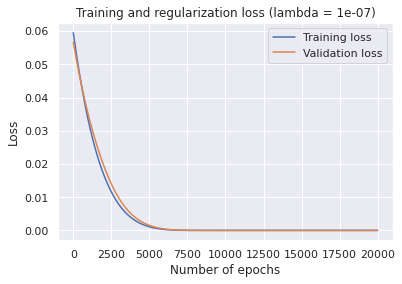

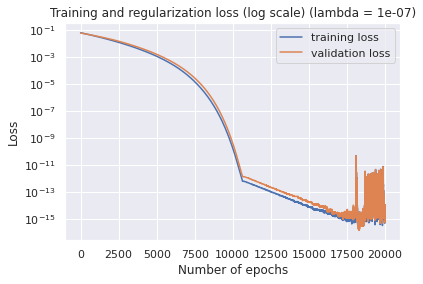

In [95]:
evaluate_model_fully_obs(model = model_decoder_100_fully_obs,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

### 1000 Samples

In [96]:
dataset_size = 1250
datagen = init_datagen_gauss_fully_obs(dataset_size)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

Dataset size: 1250

Training size: 1000
Validation size: 250


In [99]:
model_decoder_1000_fully_obs =  neuron_unit_decoder_fully_obs(datagen.train_size).to(device)

model_training_params = train_decoder_fully_obs(model_decoder_1000_fully_obs, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4013/20000 [00:42<02:54, 91.42it/s] 

iteration 4000/20000 | train loss: 2.241502017769634e-15


 40%|████      | 8010/20000 [01:25<02:01, 98.47it/s] 

iteration 8000/20000 | train loss: 0.0


 60%|██████    | 12019/20000 [02:07<01:22, 96.49it/s] 

iteration 12000/20000 | train loss: 0.0


 80%|████████  | 16013/20000 [02:50<00:43, 90.73it/s] 

iteration 16000/20000 | train loss: 0.0


100%|██████████| 20000/20000 [03:32<00:00, 94.16it/s] 

iteration 20000/20000 | train loss: 0.0


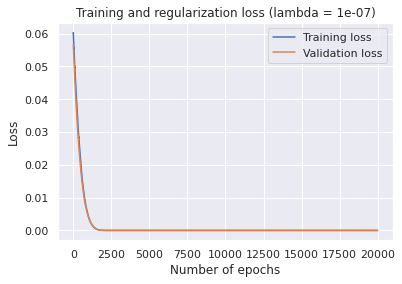

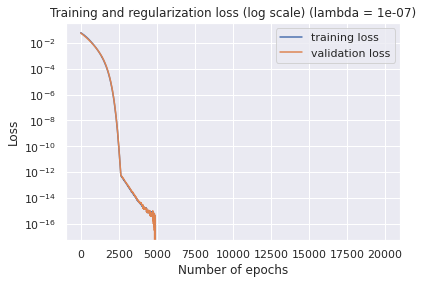

In [101]:
evaluate_model_fully_obs(model = model_decoder_1000_fully_obs,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

## Poisson input

In [56]:
class neuron_unit_decoder_fully_obs(nn.Module): 
  '''
  Fully observed decoder model for sanity check 
  '''
  def __init__(self,train_size, var = 1 ):
    super().__init__()
    self.linear1 = nn.Linear(10,1) 
    self.act1 = nn.Sigmoid()
    # self.h_activity_vec = torch.nn.Parameter(torch.normal(0,var, size=(train_size,1)))     
    # nn.init.constant_(self.linear1.weight[0,-1].data, 1)
    
  def forward(self, x, isVal = False):    
    if isVal == False:
        # input_wo_time = x[:,:-1].to(device) # Exclude the timepoint column [1,9]
        # timepoint = x[:,-1].to(device) # [1]
        input_to_network = x
        # input_to_network = torch.cat((input_wo_time, self.h_activity_vec[timepoint.long()-1]), dim = 1).to(device) # [1,10]
        
    if isVal == True:
        input_to_network = x
        assert input_to_network.shape[1] == self.linear1.in_features, "The validation dataset must have the same number of features as the model's input synapses"

    x = input_to_network
    x = self.linear1(x)
    x = self.act1(x)
    return x

In [57]:
def generate_dataset_poisson_fully_obs(dataset_size, rate_type, rate = 1,val_ratio = VAL_RATIO, batch_size = BATCH_SIZE, num_features = NUM_FEATURES, add_GWN  = False ):
    '''
    
    '''
    # Example: 
    # Total datset size = 1250 samples
    # Training set of 1000 samples, test set of 250 samples
    
    # x = torch.normal(0, 1, size=(dataset_size,num_features)).to(device) # Mean = 0, std = 1
    if rate_type == 'variable':
        rates = torch.rand(dataset_size, num_features)* rate # Rates between [0,1) 
    elif rate_type == 'constant':
        rates = torch.ones(dataset_size, num_features)* rate
    x = torch.poisson(rates).to(device)
    
    if add_GWN:
        noise = gen_GWN(dataset_size, num_features).to(device)
        x = x + noise
    
    train_size = int((1-val_ratio)*dataset_size)
    val_size = int(val_ratio*dataset_size)

    inputs = x[:train_size]
    inputs_val = x[train_size:]
    
    original =  inputs[:,-1].reshape(train_size,1)

    # print(f'Train input with shape {inputs.shape} = \n{inputs} \n\nTest input with shape {inputs_val.shape} = \n{inputs_val}')
    
    # Generate outputs using the encoder model
    with torch.no_grad():
      output = model_e(inputs)
      output_val = model_e(inputs_val)
    
    # print(f'Output shape: {output.shape}\nOutput val shape: {output_val.shape}')
    
    timepoints = torch.arange(start = 1, end = inputs.shape[0]+1).to(device) 
    timepoints = torch.reshape(timepoints,(inputs.shape[0],1))
    # print(f'timepoints shape: {timepoints.shape}')

    # Do the same operations for the validation set
    timepoints_val = torch.arange(start = 1, end = inputs_val.shape[0]+1).to(device) 
    timepoints_val = torch.reshape(timepoints_val, (inputs_val.shape[0],1))
    # print(f'timepoints_val shape: {timepoints_val.shape}')

    input_w_time = torch.cat((inputs, timepoints), dim = 1)
    # print(input_w_time[0]) 

    input_w_time_val = torch.cat((inputs_val, timepoints_val), dim = 1)
    # print(input_w_time_val[0])

    # Create the input with missing 10th neuron values
    inputs = inputs.to(device)
    inputs_val = inputs_val.to(device)

    input_w_hidden = inputs[:,:9].clone() # [1000,9]   # Change '9' for future features (not 10)
    input_w_hidden_val = inputs_val[:,:9].clone()

    # print(input_w_hidden)
    input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim = 1).to(device) # [1000,10]
    # print(input_w_time_hidden)
    input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim = 1).to(device)
    
    # This gets passed on to the decoder network as the input (x)

    # Creating the dataloader
    # train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
    train_ds_hidden_params = TensorDataset(inputs, output)
    test_ds_hidden_params = TensorDataset(inputs_val, output_val)
    
    print(inputs.shape, inputs_val.shape)


    # batch_size = 256
    train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle = True)
    train_dl_hidden.device = device

    test_dl_hidden = DataLoader(test_ds_hidden_params, batch_size , shuffle = True)
    test_dl_hidden.device = device 


    next(iter(train_dl_hidden))
    next(iter(test_dl_hidden))
    
    return inputs, output, original, input_w_time_hidden, train_dl_hidden, test_dl_hidden

In [58]:
def init_datagen_poisson_fully_obs(dataset_size, rate_type, rate, val_ratio = VAL_RATIO):
    
    datagen = namedtuple('datagen',["inputs","output", "original","input_w_time_hidden", "train_dl_hidden", "test_dl_hidden", "train_size", "val_size"])
    datagen.train_size = int((1-val_ratio)*dataset_size)
    datagen.val_size = int(val_ratio*dataset_size)
    datagen.inputs, datagen.output, datagen.original, datagen.input_w_time_hidden, datagen.train_dl_hidden, datagen.test_dl_hidden= generate_dataset_poisson_fully_obs(dataset_size, rate_type, rate)
    return datagen

In [59]:
def run_dataset_sweep_poisson_fully_obs(dataset_size_list, rate_type, rate = 1, n_epochs = 20000, var = 1):
    for dataset_size in dataset_size_list:
        
        print(f'Training on {dataset_size} samples... \n\n')
        datagen = init_datagen_poisson(dataset_size, rate_type, rate)
        model_iter = neuron_unit_decoder_w_hidden_val_fixed(datagen.train_size, var).to(device)
        model_training_params = train_decoder_var_penalty_val_fix(model_iter, datagen, loss_fn, var_coeff = 1, n_epochs = n_epochs)
        
        evaluate_model(model = model_iter,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )
    return

In [60]:
def train_decoder_fully_obs(model, datagen, loss_fn, var_coeff, n_epochs=50, learning_rate=1e-4):

  params = model.parameters()
  optimizer = torch.optim.Adam(params, lr=learning_rate)
  
  model_training_params = dict()
  model_training_params['loss_vals'] = []
  # model_training_params['l2_loss_vals'] = []
  model_training_params['validation_loss'] = []
  model_training_params['n_epochs'] = n_epochs
  model_training_params['corr_vals'] = []
  gt_var = torch.var(datagen.original)

  for i in tqdm(range(n_epochs)):
    epoch_loss= []
    epoch_l2_loss = [] 
    epoch_val_loss = []
    
    for xb,yb in datagen.train_dl_hidden:
      out = model(xb).to(device)
      yb = yb.to(device)
      loss = loss_fn(out, yb)
            
      # hidden_var = torch.var(model.h_activity_vec)
      # var_diff  = (hidden_var-gt_var)**2
      # var_loss = torch.maximum(var_diff,torch.tensor(0))
      # l2_loss = var_loss 
      # loss = loss + var_loss*var_coeff 
      
    # norm = torch.linalg.vector_norm(model.h_activity_vec, ord=l_norm)
      # l2_loss = n_lambda * norm
      # loss = loss + l2_loss
               
      
      
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
      epoch_loss.append(loss.item())
      # epoch_l2_loss.append(l2_loss.item())
    
    
    with torch.no_grad():
        model.eval()
        for xb, yb in datagen.test_dl_hidden:
            pred = model(xb, isVal = True).to(device)
            yb = yb.to(device)
            val_loss = loss_fn(pred,yb)
            epoch_val_loss.append(val_loss.item())
            

    # corr = r2_loss(model.h_activity_vec, datagen.original)
    # model_training_params['corr_vals'].append(corr)
 
    model_training_params['loss_vals'].append(sum(epoch_loss)/len(epoch_loss))
    # model_training_params['l2_loss_vals'].append(sum(epoch_l2_loss)/len(epoch_l2_loss))
    model_training_params['validation_loss'].append(sum(epoch_val_loss)/len(epoch_val_loss))
    
    
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | train loss: {loss.item():}')

  return model_training_params

### 100 samples

In [62]:
dataset_size = 125
datagen = init_datagen_poisson_fully_obs(dataset_size, rate_type = 'constant', rate = 1)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

torch.Size([100, 10]) torch.Size([25, 10])
Dataset size: 125

Training size: 100
Validation size: 25


In [63]:
model_decoder_100_fully_obs =  neuron_unit_decoder_fully_obs(datagen.train_size).to(device)

model_training_params = train_decoder_fully_obs(model_decoder_100_fully_obs, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4060/20000 [00:07<00:29, 536.89it/s]

iteration 4000/20000 | train loss: 0.014656071551144123


 40%|████      | 8095/20000 [00:15<00:22, 531.79it/s]

iteration 8000/20000 | train loss: 0.0009717218345031142


 61%|██████    | 12102/20000 [00:22<00:14, 532.07it/s]

iteration 12000/20000 | train loss: 1.2236124575792928e-06


 80%|████████  | 16061/20000 [00:30<00:07, 525.44it/s]

iteration 16000/20000 | train loss: 8.238742533247384e-14


100%|██████████| 20000/20000 [00:37<00:00, 529.51it/s]

iteration 20000/20000 | train loss: 2.1671553948902824e-15


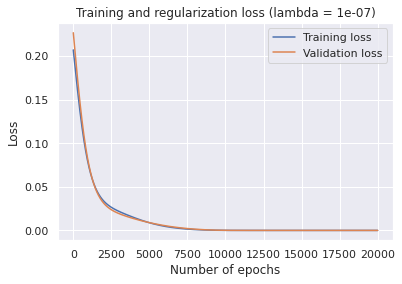

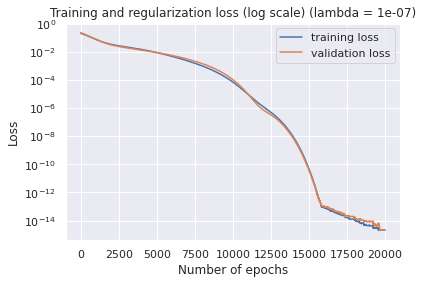

In [74]:
evaluate_model_fully_obs(model = model_decoder_100_fully_obs,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

In [71]:
from helper_functions import plot_correlation_outputs

### 1000 Samples

In [84]:
dataset_size = 1250
datagen = init_datagen_poisson_fully_obs(dataset_size, rate_type = 'constant', rate = 1)
print(f'Dataset size: {dataset_size}\n\nTraining size: {datagen.train_size}\nValidation size: {datagen.val_size}') 

torch.Size([1000, 10]) torch.Size([250, 10])
Dataset size: 1250

Training size: 1000
Validation size: 250


In [85]:
model_decoder_1000_fully_obs =  neuron_unit_decoder_fully_obs(datagen.train_size).to(device)

model_training_params = train_decoder_fully_obs(model_decoder_1000_fully_obs, datagen, loss_fn, var_coeff = 1, n_epochs = 20000)

 20%|██        | 4012/20000 [00:42<02:58, 89.47it/s] 

iteration 4000/20000 | train loss: 8.154396347612516e-15


 40%|████      | 8018/20000 [01:24<02:02, 97.53it/s] 

iteration 8000/20000 | train loss: 0.0


 60%|██████    | 12010/20000 [02:06<01:21, 98.36it/s] 

iteration 12000/20000 | train loss: 0.0


 80%|████████  | 16013/20000 [02:48<00:42, 93.42it/s] 

iteration 16000/20000 | train loss: 0.0


100%|██████████| 20000/20000 [03:30<00:00, 94.96it/s] 

iteration 20000/20000 | train loss: 0.0


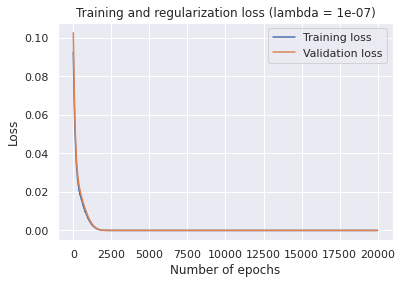

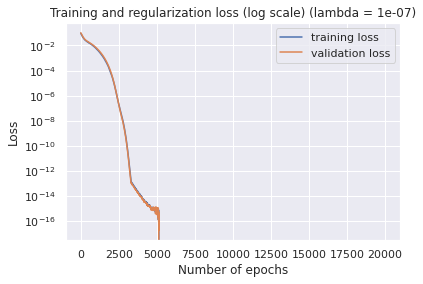

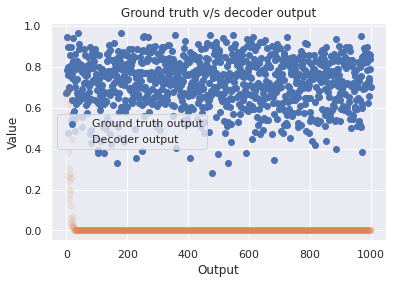

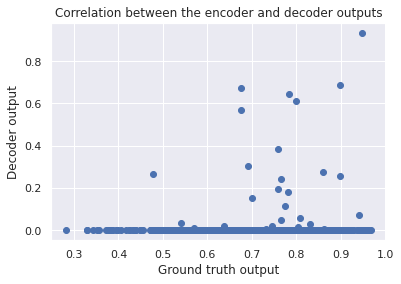

In [88]:
evaluate_model_fully_obs(model = model_decoder_1000_fully_obs,
               datagen = datagen,
               model_training_params = model_training_params, 
               l2_lambda = 10e-8,
               reg_flag = False,
               corr_flag = False,
               )

## Plotting functions


In [64]:
def plot_loglosses(
    num_epochs, loss_vals, l2_lambda, validation_loss, reg_flag, l2_loss_vals = []
):
    plt.plot(
        np.linspace(1, num_epochs, num_epochs).astype(int),
        loss_vals,
        label="training loss",
    )

    if reg_flag:
        plt.plot(
            np.linspace(1, num_epochs, num_epochs).astype(int),
            l2_loss_vals,
            label="regularization loss",
        )

    plt.plot(
        np.linspace(1, num_epochs, num_epochs).astype(int),
        validation_loss,
        label="validation loss",
    )
    plt.title(
        "Training and regularization loss (log scale) (lambda = {0})".format(l2_lambda)
    )
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [65]:
def lossplot(epochs, loss_vals, l2_lambda, val_loss, reg_flag, l2_loss_vals = []):

    plt.plot(
        np.linspace(1, epochs, epochs).astype(int), loss_vals, label="Training loss"
    )
    if reg_flag:
        plt.plot(
            np.linspace(1, epochs, epochs).astype(int),
            l2_loss_vals,
            label="Regularization loss",
        )
    plt.plot(
        np.linspace(1, epochs, epochs).astype(int), val_loss, label="Validation loss"
    )
    plt.title("Training and regularization loss (lambda = {0})".format(l2_lambda))
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [89]:
def evaluate_model_fully_obs(
    model,
    datagen,
    model_training_params,
    l2_lambda,
    alpha=0.1,
    reg_flag=True,
    corr_flag=True,
):
    

    num_epochs = model_training_params["n_epochs"]
    loss_vals = model_training_params["loss_vals"]
    # l2_loss_vals = model_training_params["l2_loss_vals"]
    validation_loss = model_training_params["validation_loss"]
    
    #Plot the inputs over the activation function'
    
    
    lossplot(num_epochs, loss_vals, l2_lambda, validation_loss, reg_flag)
    plot_loglosses(
        num_epochs, loss_vals, l2_lambda, validation_loss, reg_flag
    )
    # plot_inferred_vs_actual_params(model, datagen, alpha=alpha)
    # plot_output_encoder_vs_decoder(model, datagen, alpha=alpha)
    # plot_correlation_params(model, datagen, alpha=alpha)
    # plot_correlation_outputs(model, datagen, alpha=alpha)
    # if corr_flag == True:
        # corr_vals = model_training_params["corr_vals"]
        # plot_corr_vs_epochs(num_epochs, corr_vals)

- Negative correlation 
- generate correlated poisson inputs 
- noise
- changing the variance of the unobsereved inputs 